# Jet Detection – Tek Foto Yükle + Tespit/Sınıflandırma (MMDetection)

Bu notebook:
- **Tek fotoğraf** yüklemeyi ve tespit/sınıflandırma işlemleri yapmayı sağlar (ipywidgets `FileUpload`).
- Eğitilmiş **Cascade R-CNN** modelini yükler.
- Görsel üzernde **tespit + sınıflandırma** yapar.
- Sonucu hem notebook içinde gösterir hem de aşadaki klasöre kaydediyor:

`C:\Users\omerf\Desktop\jet_detection_project\testing\output_test`



**Importların Kontrolü**

Eğer tüm importlar tamamsa "Imports Ok" yazısı çıkıyor.

In [3]:
import os
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules

register_all_modules()
print('Imports OK')


Imports OK


**Porje Kökü ve Dosya Yolların Ayarlandığı Yer**

In [ ]:
from pathlib import Path

# proje kökümnü buluyo
def get_project_root() -> Path:
    try:
        start = Path(__file__).resolve()
    except NameError:
        # Notebook / interactive ortam
        start = Path.cwd().resolve()

    for p in [start] + list(start.parents):
        if (p / "codes").exists() and (p / "work_dirs").exists():
            return p

    raise RuntimeError("Proje kökü bulunamadı (codes + work_dirs aranıyor)")

PROJECT_ROOT = get_project_root()

# yolların ayarlandığı yer
CONFIG_PATH = PROJECT_ROOT / "codes" / "configs" / "cascade_rcnn_convnext_tiny.py"
CKPT_PATH   = PROJECT_ROOT / "work_dirs" / "cascade_rcnn_r50_tiny" / "best_coco_bbox_mAP_epoch_21.pth"

# kontrol amaçlı çıktıları yazdıralım
print("PROJECT_ROOT :", PROJECT_ROOT)
print("CONFIG_PATH  :", CONFIG_PATH)
print("CKPT_PATH    :", CKPT_PATH)
print("CONFIG exists:", CONFIG_PATH.exists())
print("CKPT exists  :", CKPT_PATH.exists())

assert CONFIG_PATH.exists(), f"Config yok: {CONFIG_PATH}"
assert CKPT_PATH.exists(), f"Ckpt yok: {CKPT_PATH}"

DEVICE = "cuda:0"
print("DEVICE:", DEVICE)

OUT_DIR = PROJECT_ROOT / "testing" / "output_test"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)


PROJECT_ROOT : C:\Users\omerf\Desktop\jet_detection_project
CONFIG_PATH  : C:\Users\omerf\Desktop\jet_detection_project\codes\configs\cascade_rcnn_r50_tiny.py
CKPT_PATH    : C:\Users\omerf\Desktop\jet_detection_project\work_dirs\cascade_rcnn_r50_tiny\best_coco_bbox_mAP_epoch_21.pth
CONFIG exists: True
CKPT exists  : True
DEVICE: cuda:0
OUT_DIR: C:\Users\omerf\Desktop\jet_detection_project\testing\output_test


**Modelin Yüklenmesi**

In [5]:
# Modeli yüklediğim kod bloğu
model = init_detector(str(CONFIG_PATH), str(CKPT_PATH), device=DEVICE)
print('Model loaded.')


Loads checkpoint by local backend from path: C:\Users\omerf\Desktop\jet_detection_project\work_dirs\cascade_rcnn_r50_tiny\best_coco_bbox_mAP_epoch_21.pth
Model loaded.


**Görsel Seçimi**

Model yüklendikdikten sonra aşağıdaki hücre çalıştırılır ve Upload kısmından istenen görsel eklenir.

In [6]:
# Tek görsel yükleyelim
from ipywidgets import FileUpload
from IPython.display import display

uploader = FileUpload(accept='image/*', multiple=False)
display(uploader)
print('Foto seçip yükleyince bir sonraki celli çalıştır.')


FileUpload(value=(), accept='image/*', description='Upload')

Foto seçip yükleyince bir sonraki celli çalıştır.


## Inference + Kayıt + Görselleştirme (Varsayılan Ayarlar)

Aşağıdaki hücre:
- Yüklenen fotoğrafı diske yazar (geçici `_uploaded_image.*`)
- `inference_detector` ile tahmin alır
- Tespitleri **metin olarak** listeler (score threshold ile)
- Kutulu çıktıyı çizer ve `output_test` klasörüne kaydeder


Uploaded: F-22_4.jpg
Saved to: C:\Users\omerf\Desktop\jet_detection_project\_uploaded_image.jpg
Inference OK
Toplam tespit: 4 | Thr(0.3) sonrası: 3

01) F22   score=0.844  box=[177.8,293.2,1259.0,606.8]  (w=1081.2, h=313.6, area=339075)
02) F22   score=0.791  box=[98.5,187.1,760.2,373.2]  (w=661.7, h=186.1, area=123133)
03) F35   score=0.566  box=[93.5,188.1,759.6,373.7]  (w=666.1, h=185.6, area=123611)


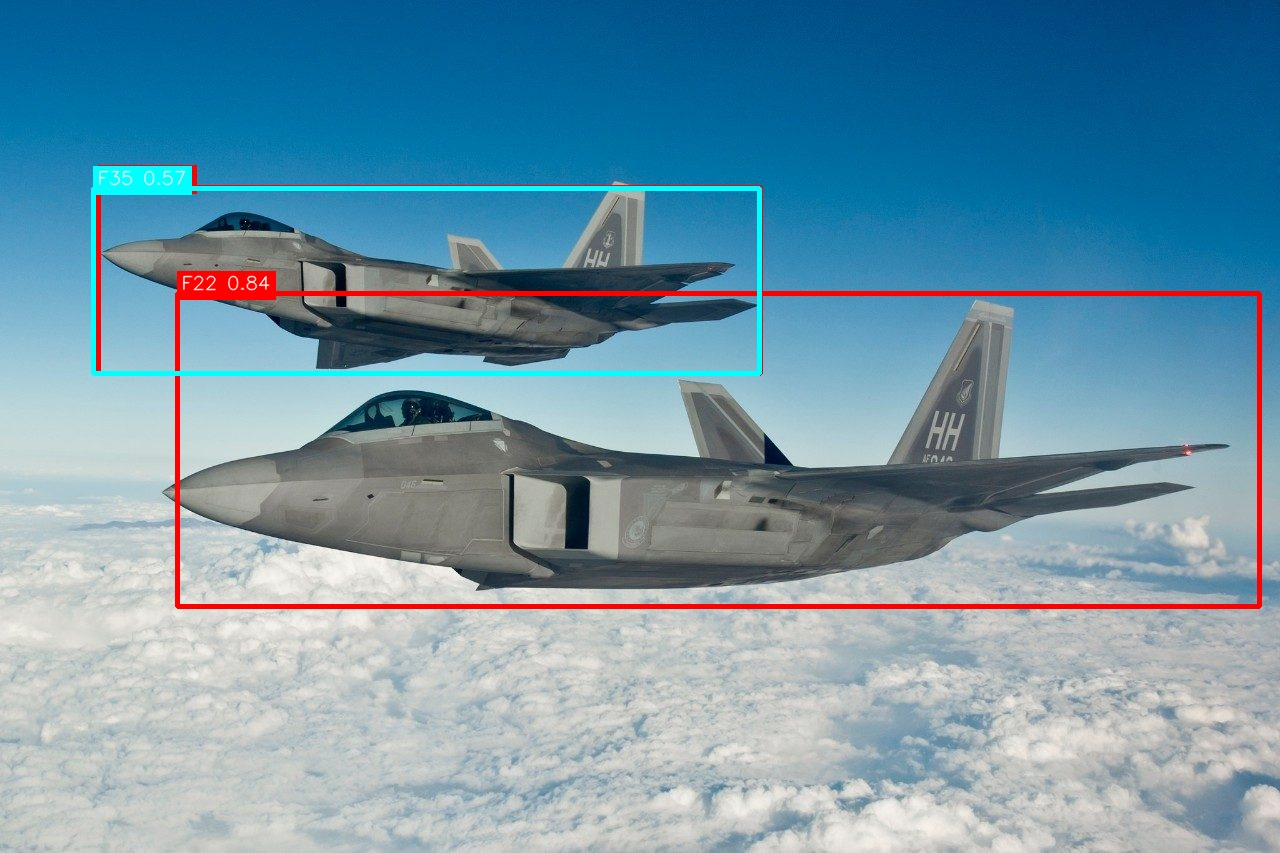

Saved visualization: C:\Users\omerf\Desktop\jet_detection_project\testing\output_test\pred_20251223_115007.jpg


In [7]:
import cv2
import numpy as np
from pathlib import Path
from datetime import datetime
from IPython.display import Image as IPImage, display


# Dinamik çizim yardımcıları
def compute_draw_params(w: int, h: int):
    # referans: 800px kısa kenar = normal görünüm
    short = min(w, h)
    scale = max(0.8, short / 900.0)

    box_th = max(2, int(round(3 * scale)))
    font_scale = 0.65 * scale
    text_th = max(1, int(round(2 * scale)) - 1)
    pad = max(2, int(round(4 * scale)))
    return box_th, font_scale, text_th, pad


def draw_boxes_opencv(img_bgr, bboxes, scores, labels, class_names, score_thr=0.30):
    h, w = img_bgr.shape[:2]
    BOX_TH, FONT_SCALE, TEXT_TH, PAD = compute_draw_params(w, h)

    keep = scores >= score_thr
    bboxes_k = bboxes[keep]
    scores_k = scores[keep]
    labels_k = labels[keep]

    palette = [
        (0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0),
        (255, 0, 255), (0, 255, 255)
    ]

    def safe_name(lb: int) -> str:
        if class_names is None:
            return str(lb)
        return class_names[lb] if lb < len(class_names) else str(lb)

    def color_for_label(lb: int):
        return palette[int(lb) % len(palette)]

    draw = img_bgr.copy()

    # skor sıralı çiz (yüksek skor üste)
    order = np.argsort(-scores_k) if len(scores_k) else []
    for idx in order:
        bb = bboxes_k[idx]
        sc = float(scores_k[idx])
        lb = int(labels_k[idx])

        x1, y1, x2, y2 = map(int, bb)
        color = color_for_label(lb)

        cv2.rectangle(draw, (x1, y1), (x2, y2), color, thickness=BOX_TH)

        text = f"{safe_name(lb)} {sc:.2f}"
        (tw, th), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, FONT_SCALE, TEXT_TH
        )

        # yazı kadraj dışına taşmasın
        x_text = max(0, x1)
        y_text = max(y1, th + PAD + 2)

        # arkaplan kutusu
        cv2.rectangle(
            draw,
            (x_text, y_text - th - PAD * 2),
            (x_text + tw + PAD * 2, y_text + baseline),
            color,
            thickness=-1
        )

        # yazı
        cv2.putText(
            draw,
            text,
            (x_text + PAD, y_text - PAD),
            cv2.FONT_HERSHEY_SIMPLEX,
            FONT_SCALE,
            (255, 255, 255),
            thickness=TEXT_TH,
            lineType=cv2.LINE_AA
        )

    return draw


# 1) Upload kontrol + dosyayı diske yaz
if getattr(uploader, "value", None) is None or len(uploader.value) == 0:
    raise RuntimeError("Önce yukarıdaki uploader'dan 1 foto yükle.")

val = uploader.value
if isinstance(val, dict):
    upload_name = next(iter(val.keys()))
    content = val[upload_name]["content"]
    suffix = Path(upload_name).suffix.lower() or ".jpg"
elif isinstance(val, (list, tuple)):
    item = val[0]
    upload_name = item.get("name", "upload.jpg")
    content = item["content"]
    suffix = Path(upload_name).suffix.lower() or ".jpg"
else:
    raise TypeError(f"Beklenmeyen uploader.value tipi: {type(val)}")

IN_PATH = Path(PROJECT_ROOT) / f"_uploaded_image{suffix}"
with open(IN_PATH, "wb") as f:
    f.write(content)

print("Uploaded:", upload_name)
print("Saved to:", IN_PATH)


# 2) Inference
result = inference_detector(model, str(IN_PATH))
print("Inference OK")


# 3) Metin çıktısı (sağlam + skora göre sıralı)
pred = result.pred_instances
bboxes = pred.bboxes.detach().cpu().numpy()
scores = pred.scores.detach().cpu().numpy()
labels = pred.labels.detach().cpu().numpy().astype(int)

class_names = None
if hasattr(model, "dataset_meta") and model.dataset_meta is not None:
    class_names = model.dataset_meta.get("classes", None)

if class_names is None:
    if labels.size > 0:
        class_names = [str(i) for i in range(int(labels.max()) + 1)]
    else:
        class_names = []

SCORE_THR = 0.30
keep = scores >= SCORE_THR

bboxes_k = bboxes[keep]
scores_k = scores[keep]
labels_k = labels[keep]

print(f"Toplam tespit: {len(scores)} | Thr({SCORE_THR}) sonrası: {len(scores_k)}\n")

def _safe_name(lb: int) -> str:
    return class_names[lb] if (class_names is not None and lb < len(class_names)) else str(lb)

order = np.argsort(-scores_k) if len(scores_k) else []
for i, idx in enumerate(order, 1):
    x1, y1, x2, y2 = bboxes_k[idx]
    sc = float(scores_k[idx])
    lb = int(labels_k[idx])
    w = x2 - x1
    h = y2 - y1
    area = w * h
    print(
        f"{i:02d}) {_safe_name(lb):<4}  score={sc:.3f}  "
        f"box=[{x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f}]  "
        f"(w={w:.1f}, h={h:.1f}, area={area:.0f})"
    )


# 4) Dinamik OpenCV çizim + kaydet + göster
img = cv2.imread(str(IN_PATH))
if img is None:
    raise RuntimeError(f"Görüntü okunamadı: {IN_PATH}")

draw = draw_boxes_opencv(
    img_bgr=img,
    bboxes=bboxes,
    scores=scores,
    labels=labels,
    class_names=class_names,
    score_thr=SCORE_THR
)

OUT_DIR = Path(OUT_DIR) if "OUT_DIR" in globals() else (Path(PROJECT_ROOT) / "testing" / "predicted_images")
OUT_DIR.mkdir(parents=True, exist_ok=True)

ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file = OUT_DIR / f"pred_{ts}.jpg"
cv2.imwrite(str(out_file), draw)

display(IPImage(filename=str(out_file)))
print("Saved visualization:", out_file)


In [ ]:
# (Opsiyonel) Tespitleri crop'layıp kaydetme 
CROP_DIR = PROJECT_ROOT / '_crops'
CROP_DIR.mkdir(exist_ok=True)

img = cv2.imread(str(IN_PATH))

for i, (bb, sc, lb) in enumerate(zip(bboxes_k, scores_k, labels_k), 1):
    x1, y1, x2, y2 = bb.astype(int)
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(img.shape[1]-1, x2); y2 = min(img.shape[0]-1, y2)

    crop = img[y1:y2, x1:x2]
    name = class_names[lb] if lb < len(class_names) else str(lb)
    outp = CROP_DIR / f'{i:02d}_{name}_score{sc:.3f}.jpg'
    cv2.imwrite(str(outp), crop)

print('Crops saved to:', CROP_DIR)
